### Import packages

In [4]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import signal
import glob
import antropy
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from scipy.signal import butter, sosfilt, sosfreqz, detrend,stft
import math
from scipy.signal import stft,find_peaks
from scipy.stats import kurtosis,skew
import seaborn as sns

### Extract Raw sensor readings from raw files

In [5]:
sensor_list = ['IMU_1_x','IMU_1_y','IMU_1_z','Prox','IMU_2_x','IMU_2_y','IMU_2_z']

In [6]:
### Convert labels to 1 (chewing) or 0 (non-chewing)
def chewing_label(row):
    if '1' in str(row['label']) or row['label'] == 0 or row['label'] == 2:
        return 1
    else:
        return 0
###  Create dataframes from raw readings and assign eating and chewing labels   
def raw_process(raw,labelled,offset):
    raw_transposed = raw.T
    labelled = labelled.dropna(how = 'all')
    data_pt = labelled.iloc[:,0]
    raw_transposed = raw_transposed.rename(columns = {0:'IMU_1_x',1:'IMU_1_y',2:'IMU_1_z',3:'Prox',4:'IMU_2_x',5:'IMU_2_y',6:'IMU_2_z'})
    raw_transposed['data_pt'] = raw_transposed.index.astype(float)
    labelled = labelled.rename(columns = {0:'data_pt',1:'timestamp',2:'label'})
    labelled['data_pt'] = labelled['data_pt']+offset
    labelled['label_chewing'] = labelled.apply(lambda row:chewing_label(row),axis = 1)
    labelled = labelled.drop_duplicates(subset = 'data_pt')
    sensor_labelled = pd.merge(labelled[['data_pt','label','label_chewing']],raw_transposed,on = 'data_pt',how = 'right')
    sensor_labelled['label_chewing'] = sensor_labelled['label_chewing'].fillna(0)
    sensor_labelled = sensor_labelled.sort_values(by = 'data_pt')
    sensor_laballed = sensor_labelled.reset_index(drop = True)
    sensor_labelled = sensor_labelled.set_index('data_pt',drop = False)
    eating_label = []
    eating = 0
    for index,row in sensor_labelled[['label']].iterrows():
        if '1' in str(row['label']):
            eating = 1
        eating_label.append(eating)
        if '2' in str(row['label']):
            eating = 0
    sensor_labelled['label_eating'] = eating_label
    sensor_labelled.dropna(axis = 0,subset = sensor_list,inplace = True)
    return sensor_labelled

In [7]:
### data path
label_data_path = r'./label/label_1st'
original_data_path = r'./original/data_1st'

## read from raw files, separate to sensor readings and label dataframes

pattern = f'{label_data_path}/*/n_sensor_data.*'

sensor_ts_lst = []
for f in glob.glob(pattern):

    sheet_dict_name = f
    sheet_dict = pd.read_excel(sheet_dict_name,sheet_name = None)

    for name,sheet in sheet_dict.items():
        labelled = sheet.iloc[9:,0:3] # after 9th row (0-index) first 3 cols,

        raw_file_name = os.path.join(original_data_path,f.split('\\')[1],f'{name}_sensor_data.csv') # 找original文件

        if os.path.isfile(raw_file_name):
            raw = pd.read_csv(raw_file_name).iloc[0:7]
            # get the offset
            offset = sheet.iloc[11, 3]
            sensor_ts = raw_process(raw,labelled,offset)
            sensor_ts['File'] = raw_file_name
            # add the offset
            #sensor_ts.iloc[:, 0] = sensor_ts.iloc[:, 0] + offset
            sensor_ts_lst.append(sensor_ts)
        else:
            print(raw_file_name)

print(sensor_ts_lst)
sensor_ts_df = pd.concat(sensor_ts_lst,axis = 0)

[]


ValueError: No objects to concatenate

In [6]:
sensor_ts_df['label'] = sensor_ts_df['label'].astype(str)
sensor_ts_df['File'] = sensor_ts_df['File'].astype(str)
sensor_ts_df =  sensor_ts_df.reset_index(drop = True)

In [27]:
sensor_ts_df

,data_pt,label,label_chewing,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z,label_eating,File
data_pt,,,,,,,,,,,,
561.0,561.0,1,1.0,-0.05,-0.99,-0.15,212.0,0.95,-0.21,0.19,1.0,./original/data_1st\7.21_breakfast\1_sensor_da...
562.0,562.0,NaN,0.0,-0.06,-0.99,-0.14,228.0,0.97,-0.21,0.18,1.0,./original/data_1st\7.21_breakfast\1_sensor_da...
563.0,563.0,NaN,0.0,-0.07,-1.00,-0.13,245.0,0.99,-0.21,0.12,1.0,./original/data_1st\7.21_breakfast\1_sensor_da...
564.0,564.0,NaN,0.0,-0.07,-0.97,-0.11,262.0,0.95,-0.27,0.09,1.0,./original/data_1st\7.21_breakfast\1_sensor_da...
565.0,565.0,NaN,0.0,-0.10,-1.01,-0.10,265.0,0.92,-0.25,0.16,1.0,./original/data_1st\7.21_breakfast\1_sensor_da...
...,...,...,...,...,...,...,...,...,...,...,...,...
12213.0,12213.0,NaN,0.0,-0.28,-0.99,-0.10,1192.0,0.80,-0.23,0.52,0.0,./original/data_1st\8.3_breakfast\2_sensor_dat...
12214.0,12214.0,NaN,0.0,-0.28,-0.99,-0.09,1197.0,0.82,-0.22,0.50,0.0,./original/data_1st\8.3_breakfast\2_sensor_dat...
12215.0,12215.0,NaN,0.0,-0.28,-0.98,-0.08,1203.0,0.82,-0.23,0.49,0.0,./original/data_1st\8.3_breakfast\2_sensor_dat...


In [28]:
## Export to parquet with offset
sensor_ts_df.to_parquet(r"./sensor_ts_df_offset.parquet",engine = 'pyarrow')

ArrowTypeError: ("Expected bytes, got a 'int' object", 'Conversion failed for column label with type object')

In [9]:
def plot_stft(signal,win_length,ax):
    f,t,Zxx = stft(signal,fs = 60,nperseg = win_length,detrend = 'constant',boundary = 'constant')
    ax.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=np.abs(Zxx).max(), shading='gouraud')

def filtering(signal,lowcut,highcut,fs):
    
    def butter_bandpass(lowcut, highcut, fs, order=5):
        nyquist = 0.5 * fs
        low = lowcut / nyquist
        high = highcut / nyquist
        sos = butter(order, [low, high], btype='band', output='sos')
        return sos

    sos = butter_bandpass(lowcut, highcut, fs)

    filtered_data = sosfilt(sos, signal)
    return filtered_data

In [10]:
### To visualize some signals from the first file and their STFT
def visualize_signals(start,end,stft_resolution):
    eating_slice = sensor_ts_df.loc[sensor_ts_df['File'] == r"./original/data_1st/7.21_din/0_sensor_data.csv"].iloc[start:end+30].reset_index(drop = True)
    # print(eating_slice)
    eating_slice['label'] = eating_slice.apply(lambda row: np.nan if row['label'] == 'nan' else int(row['label'][0]),axis = 1)
    fig,ax = plt.subplots(4,2,figsize = (10,12))
    IMU_1_mag = np.sqrt(eating_slice['IMU_1_x']**2+eating_slice['IMU_1_y']**2+eating_slice['IMU_1_z']**2)
    ax[0,0].plot([i for i in range(len(eating_slice))],IMU_1_mag)
    plot_stft(IMU_1_mag,stft_resolution,ax[0,1])
    IMU_2_mag = np.sqrt(eating_slice['IMU_2_x']**2+eating_slice['IMU_2_y']**2+eating_slice['IMU_2_z']**2)
    ax[1,0].plot([i for i in range(len(eating_slice))],IMU_2_mag)
    plot_stft(IMU_2_mag,stft_resolution,ax[1,1])
    eating_slice.plot(y = 'Prox',ax = ax[2,0])
    plot_stft(eating_slice['Prox'],stft_resolution,ax[2,1])
    ax[3,0].scatter([i for i in range(len(eating_slice))],y = eating_slice['label'])
    ax[3,1].scatter([i for i in range(len(eating_slice))],y = eating_slice['label'])
    plt.xlim(0,len(eating_slice)-1)

In [12]:
## Extract 2s window segments for a sensor
def extract_frames(sensor):
    window_size = 120
    window_step = 60
    start = 0
    end = len(sensor_ts_df) - 1
    ts_lst = []
    for win_start in range(start,end,window_step):
        win_end = win_start + window_size
        if win_end >= end:
            break
        frame = sensor_ts_df.iloc[win_start:win_end]
        if np.any(np.abs(frame['Prox'].diff()) > 100): ## discard the window if it contains diff above the threshold
            continue
        Prox_frame = frame[sensor].to_frame().T
        Prox_frame.columns = [i for i in range(120)]
        if frame.iloc[-1]['data_pt'] < frame.iloc[0]['data_pt']:
            continue
        if frame['label_eating'].mean() > 0.5:
            Prox_frame['label_eating'] = 1
            Prox_frame['label_chewing_count'] = frame['label_chewing'].sum()
        else:
            Prox_frame['label_eating'] = 0
            Prox_frame['label_chewing_count'] = 0
        Prox_frame['win_start'] = win_start
        Prox_frame['win_end'] = win_end
        ts_lst.append(Prox_frame)
    ts_df = pd.concat(ts_lst,axis = 0).reset_index(drop = True)
    return ts_df

In [13]:
## Visualize 2s window segments, compare between 1 and 0 cases in terms of psd, fft, peaks, etc.
def visualize(ts_df,prom_threshold):
    fig,ax = plt.subplots(2,3,figsize = (20,10))
    eating = ts_df.loc[ts_df['label_eating'] == 1].sample(n=3)
    non_eating = ts_df.loc[ts_df['label_eating'] == 0].sample(n=3)
    for i in range(6):
        if i < 3:
            eating_signal = eating.iloc[i][[x for x in range(120)]]
            count = eating.iloc[i]['label_chewing_count']
            #f_psd, Pxx_dens = signal.periodogram(eating_signal, fs = 60)
            #f,t,Zxx = stft(filtering(eating.iloc[i][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            peaks = find_peaks(eating_signal, height = 100,prominence= prom_threshold)
            ax[0,i].plot([x for x in range(120)],eating.iloc[i][[x for x in range(120)]])
            [ax[0,i].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(eating.iloc[i],ax[0,i+3])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[0,i+3].plot(f_psd,Pxx_dens_dB)
            ##ax[0,i+3].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[0,i+3].plot(f,Pxx_dens)
            print(count)
        else:
            non_eating_signal = non_eating.iloc[i-3][[x for x in range(120)]]
            #f_psd, Pxx_dens = signal.periodogram(non_eating.iloc[i-3][[x for x in range(120)]], fs = 60)
            ##f,t,Zxx = stft(filtering(non_eating.iloc[i-3][[x for x in range(120)]],0.1,3,60),120,nperseg = 20,scaling = 'psd')
            ax[1,(i-3)].plot([x for x in range(120)],non_eating.iloc[i-3][[x for x in range(120)]])
            peaks = find_peaks(non_eating_signal, height = 100,prominence=prom_threshold)
            [ax[1,(i-3)].axvline(p, c='C3', linewidth=0.3) for p in peaks[0]]
            #plot_fft(non_eating.iloc[i-3],ax[1,i])
            #Pxx_dens_dB = 10*np.log10(Pxx_dens/Pxx_dens.max())
            #ax[1,i].plot(f_psd,Pxx_dens_dB)
            ##ax[1,i].plot(f,(np.abs(Zxx)**4).mean(axis = 1) / ((np.abs(Zxx)**2).mean(axis = 1))**2 - 2)
            ##ax[1,i].plot(f,Pxx_dens)
    plt.show()

In [14]:
Prox_frames = extract_frames('Prox')

In [15]:
Prox_frames.iloc[113]

0                       228.0
1                       214.0
2                       206.0
3                       202.0
4                       202.0
                        ...  
119                     209.0
label_eating              1.0
label_chewing_count       0.0
win_start              7020.0
win_end                7140.0
Name: 113, Length: 124, dtype: float64

In [16]:
sensor_ts_df.iloc[13380:13500]

,data_pt,label,label_chewing,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z,label_eating,File
13380,333.0,nan,0.0,-0.03,-1.01,0.10,266.0,0.92,-0.40,0.05,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13381,334.0,nan,0.0,-0.02,-1.00,0.10,265.0,0.92,-0.39,0.03,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13382,335.0,nan,0.0,-0.04,-0.99,0.10,260.0,0.91,-0.39,0.04,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13383,336.0,nan,0.0,-0.06,-1.01,0.09,256.0,0.89,-0.39,0.06,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13384,337.0,nan,0.0,-0.05,-0.99,0.10,259.0,0.90,-0.42,0.06,0,./original/data_1st\7.21_breakfast\2_sensor_da...
...,...,...,...,...,...,...,...,...,...,...,...,...
13495,448.0,nan,0.0,0.11,-1.00,-0.04,238.0,0.87,-0.43,0.22,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13496,449.0,nan,0.0,0.12,-1.00,-0.04,237.0,0.87,-0.43,0.22,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13497,450.0,nan,0.0,0.12,-1.01,-0.03,236.0,0.86,-0.45,0.22,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13498,451.0,nan,0.0,0.12,-1.01,-0.03,236.0,0.87,-0.44,0.22,0,./original/data_1st\7.21_breakfast\2_sensor_da...


In [17]:
sensor_ts_df.iloc[13500:13620]

,data_pt,label,label_chewing,IMU_1_x,IMU_1_y,IMU_1_z,Prox,IMU_2_x,IMU_2_y,IMU_2_z,label_eating,File
13500,453.0,nan,0.0,0.12,-1.01,-0.01,237.0,0.87,-0.44,0.20,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13501,454.0,nan,0.0,0.12,-1.01,-0.01,237.0,0.88,-0.45,0.19,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13502,455.0,nan,0.0,0.11,-1.01,-0.01,235.0,0.87,-0.45,0.19,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13503,456.0,nan,0.0,0.11,-1.00,0.00,233.0,0.86,-0.45,0.19,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13504,457.0,nan,0.0,0.10,-1.01,-0.01,233.0,0.85,-0.45,0.19,0,./original/data_1st\7.21_breakfast\2_sensor_da...
...,...,...,...,...,...,...,...,...,...,...,...,...
13615,568.0,nan,0.0,0.15,-1.00,0.00,236.0,0.85,-0.50,0.21,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13616,569.0,nan,0.0,0.15,-0.99,0.01,236.0,0.85,-0.49,0.21,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13617,570.0,nan,0.0,0.15,-0.99,0.01,237.0,0.85,-0.49,0.20,0,./original/data_1st\7.21_breakfast\2_sensor_da...
13618,571.0,nan,0.0,0.14,-0.99,0.00,237.0,0.85,-0.48,0.20,0,./original/data_1st\7.21_breakfast\2_sensor_da...


3.0
1.0
3.0


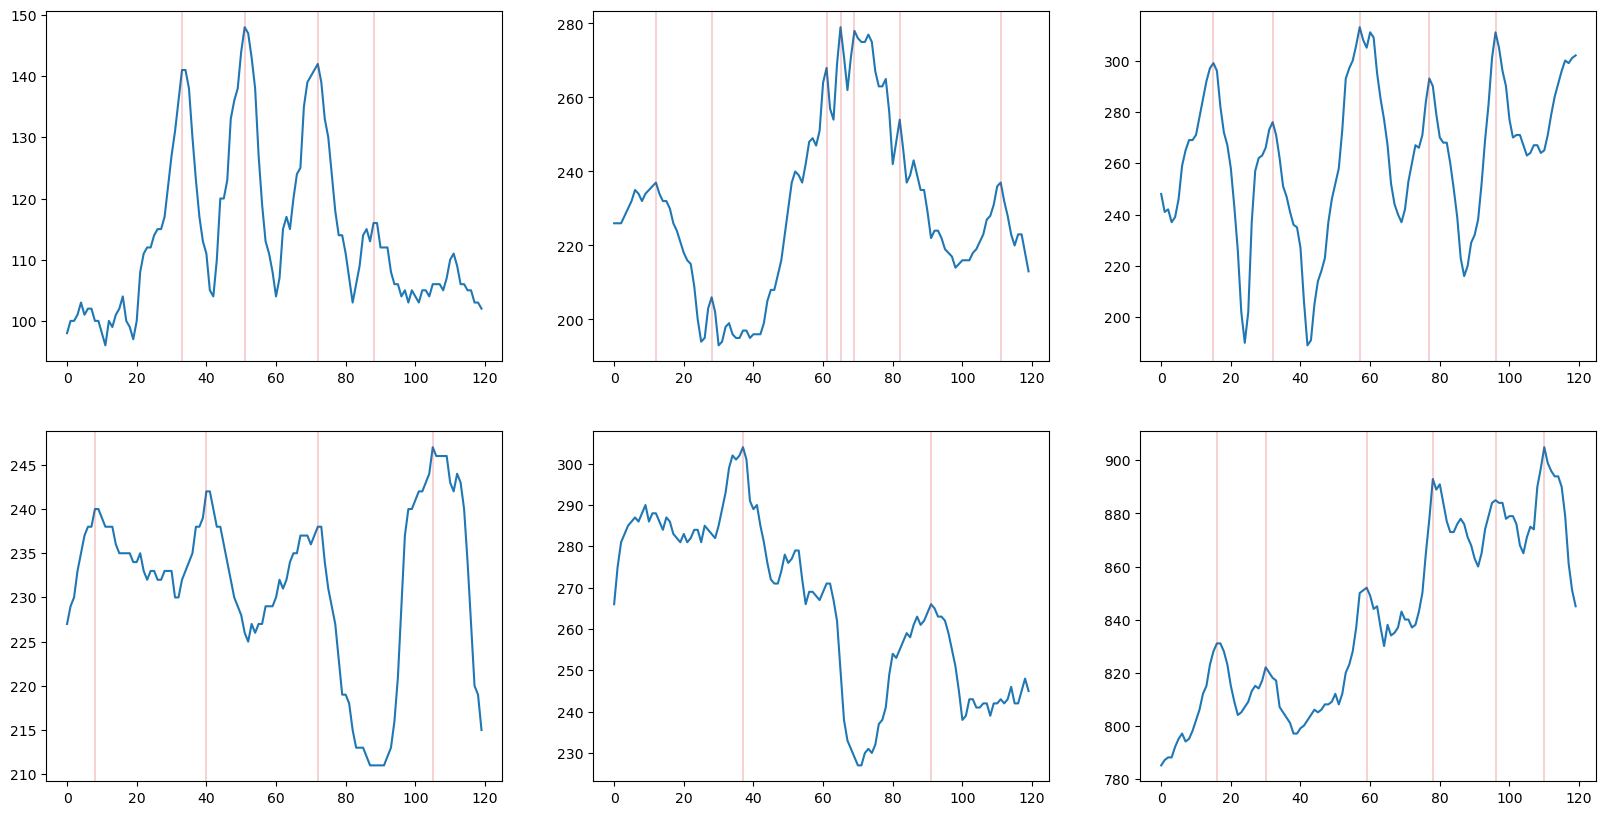

In [18]:
visualize(Prox_frames,10)